# 8 RAPID Random Forest
before and after treatments on Cle Elum Ridge   

### Notebook contents 
* Opening the netcdfs created in the *rapid_model_create_netcdf.ipynb* notebook 
* Running the Chapter 2 Bin 1 Random Forest Model on CER before and after treatments 

created by Cassie Lumbrazo\
date: October 2023\
python environment: **raster**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rioxarray
import rasterio
# import rasterstats
import scipy

In [2]:
import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

In [4]:
ds

<xarray.Dataset>
Dimensions:                   (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                         (x) float64 4.65e+05 4.65e+05 ... 4.676e+05
  * y                         (y) float64 2.111e+05 2.111e+05 ... 2.097e+05
  * band                      (band) int32 1
    spatial_ref               int32 ...
Data variables: (12/36)
    hs_rapid_set1             (band, y, x) float32 ...
    hs_rapid_set2             (band, y, x) float32 ...
    hs_rapid_set3             (band, y, x) float32 ...
    hs_rapid_set2_maskpiles   (band, y, x) float32 ...
    hs_rapid_set3_maskpiles   (band, y, x) float32 ...
    chmws_rapid               (band, y, x) float32 ...
    ...                        ...
    dah_reclass               (band, y, x) float32 ...
    dce_rapid_reclass         (band, y, x) float32 ...
    giulia_dce_rapid_reclass  (band, y, x) float64 ...
    dce_ncalm_reclass         (band, y, x) float32 ...
    hs_rapid                  (band, y, x) float32 ...
    chmas_rapid               (band, y, x) float32 ...

## Add a CHM buffer for edge effects of RAPID lidar data 
To do the buffer, we want to buffer the rapid chm, then clip the other two chm to the rapid model

In [5]:
# first creating a binary mask
# if there are values then 1, if not then 0 
chm_mask = ds['chmws_rapid'].copy(deep=True) # first cope chmws
chm_mask = chm_mask.fillna(-1000) # then filling the nans in the mask with 500 to make this easier
chm_mask = chm_mask.where(chm_mask < -50, 1) # where condition is FALSE, fill with 1 
chm_mask = chm_mask.where(chm_mask > -50, 0) # where condition is FALSE, fill with 0 

# now, we take the dce_mask and do the erosion thing with it to create the fixed mask 
fixed_mask = scipy.ndimage.binary_erosion(chm_mask, structure=np.ones((1,10,10))).astype(chm_mask.dtype) # had to add the 1 to the 50x50 for dimensions

# For the chmws mask, we do not accoutn for large edge effects, so a buffer of 5-10 meters should work. Let's do 10. 

# add the fixed mask to the dataset 
ds['chm_mask'] = xr.DataArray(fixed_mask,dims = ['band','y','x'])

# Now, go mask my OG dataset by the fixed_mask to remove the edges of dce 
ds['chmws_rapid_raw'] = ds['chmws_rapid'].copy(deep=True) # saving dce into a variable for the dataset 
ds['chmws_rapid'] = ds['chmws_rapid'].where(ds['chm_mask'] >= 1) # resaving the mask dce into dce variable 

# ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

Should do this at the begining, clip the entire dataset to it, then move on

In [6]:
ds = ds.where(ds.chmws_rapid.notnull()) # making the entire dataset null where there is no data here 

Lastly, check that the snow depth values do not have all zeros

## Calculations for change in forest structure depending on aspect

In [7]:
ds['diff_chm_rapid_snowoff'] = ds['chmws_rapid'] - ds['chm_snowoff']
ds['diff_chm_ncalm_snowoff'] = ds['chmws_ncalm'] - ds['chm_snowoff']
ds['diff_chm_rapid_ncalm'] =   ds['chmws_rapid'] - ds['chmws_ncalm']

ds['diff_chm_snowoff_rapid'] =  ds['chm_snowoff']- ds['chmws_rapid']
ds['diff_chm_snowoff_ncalm'] =  ds['chm_snowoff']- ds['chmws_ncalm']
ds['diff_chm_ncalm_rapid'] =    ds['chmws_ncalm']- ds['chmws_rapid'] 

In [8]:
# this code calculates the the change in lidar at 5 meters 
ds['lidar_canopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] < -5) # removed trees, can change this... but for now, 5
ds['lidar_nocanopychange'] = ds['diff_chm_rapid_snowoff'].where(ds['diff_chm_rapid_snowoff'] >= 0) # stayed the same 

# also, remove outliers from the change canopy 
ds['lidar_nocanopychange'] = ds['lidar_nocanopychange'].where(ds['lidar_nocanopychange'] < 40) # I saw some outliers when plotting so remove those points

# use the change canopy and no change canopy to make a binary variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange'].copy(deep=True) # first copy the variable
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['lidar_canopychange_binary'] == 0, 1) # where condition is FALSE, fill with 1
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds['diff_chm_rapid_snowoff'])
ds['lidar_canopychange_binary'] = ds['lidar_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [9]:
# create binary variable for baf
ds['baf_canopychange_binary'] = np.nan 
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].fillna(0) # then fill the nans with 0
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(~(ds['baf'] > 0), 1) # any BAF means canopy change
ds['baf_canopychange_binary'] = ds['baf_canopychange_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

# also, create this variable to call later with the lidar change
ds['baf_canopychange'] = ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 1, np.nan)
ds['baf_nocanopychange']= ds['baf_canopychange_binary'].where(ds['baf_canopychange_binary'] == 0, np.nan)

In [10]:
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0), 1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] < 0), -1) # where DAH is less than or equal to 0, then -1 for low heat index
ds['dah_binary'] = ds['dah_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

In [11]:
# the numbers above show the calculate bounds for this option
ds['aspect_north'] = ds['aspect'].where((ds['aspect'] >= 325) | (ds['aspect'] <= 55)) # greater than 300 or less than 120 north
ds['aspect_south'] = ds['aspect'].where((ds['aspect'] >= 155) & (ds['aspect'] <= 245)) # between 120 and 300 south

# also, create an aspect binary variable to use later 
ds['aspect_binary'] = np.nan
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 325) | (ds['aspect'] <= 55)), 0) # where not false (true) fill 0
ds['aspect_binary'] = ds['aspect_binary'].where(~((ds['aspect'] >= 155) & (ds['aspect'] <= 245)), 1) 

# therefore, south is 0 and north is 1 
ds['aspect_binary'] = ds['aspect_binary'].where(ds.diff_chm_rapid_snowoff.notnull()) # now, just make nans where there is no data really

Find where the forest changed or did not, on each aspect 

In [12]:
# lidar canopy change
# aspect 
ds['lidar_canopychange_north'] = ds['lidar_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_canopychange_south'] = ds['lidar_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['lidar_nocanopychange_north'] = ds['lidar_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['lidar_nocanopychange_south'] = ds['lidar_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['lidar_canopychange_dahneg'] = ds['lidar_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_canopychange_dahpos'] = ds['lidar_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['lidar_nocanopychange_dahneg'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['lidar_nocanopychange_dahpos'] = ds['lidar_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

# same, with baf canopy change
# aspect 
ds['baf_canopychange_north'] = ds['baf_canopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_canopychange_south'] = ds['baf_canopychange'].where(ds['aspect_south'] >= 0) # south

ds['baf_nocanopychange_north'] = ds['baf_nocanopychange'].where(ds['aspect_north'] >= 0) # north
ds['baf_nocanopychange_south'] = ds['baf_nocanopychange'].where(ds['aspect_south'] >= 0) # south

# dah 
ds['baf_canopychange_dahneg'] = ds['baf_canopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_canopychange_dahpos'] = ds['baf_canopychange'].where(ds['dah_binary'] == 1) # high dah

ds['baf_nocanopychange_dahneg'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == -1) # low dah
ds['baf_nocanopychange_dahpos'] = ds['baf_nocanopychange'].where(ds['dah_binary'] == 1) # high dah

In [13]:
# now, save snow depth as a variable for each of those conditions, where the values are not null
ds['hs_lidar_canopychange_north'] = ds['hs_rapid'].where(ds['lidar_canopychange_north'].notnull())
ds['hs_lidar_canopychange_south'] = ds['hs_rapid'].where(ds['lidar_canopychange_south'].notnull())
ds['hs_lidar_nocanopychange_north'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_north'].notnull())
ds['hs_lidar_nocanopychange_south'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_south'].notnull())

ds['hs_lidar_canopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahneg'].notnull())
ds['hs_lidar_canopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_canopychange_dahpos'].notnull())
ds['hs_lidar_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahneg'].notnull())
ds['hs_lidar_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['lidar_nocanopychange_dahpos'].notnull())

# same, with baf canopy change
ds['hs_baf_canopychange_north'] = ds['hs_rapid'].where(ds['baf_canopychange_north'].notnull())
ds['hs_baf_canopychange_south'] = ds['hs_rapid'].where(ds['baf_canopychange_south'].notnull())
ds['hs_baf_nocanopychange_north'] = ds['hs_rapid'].where(ds['baf_nocanopychange_north'].notnull())
ds['hs_baf_nocanopychange_south'] = ds['hs_rapid'].where(ds['baf_nocanopychange_south'].notnull())


ds['hs_baf_canopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_canopychange_dahneg'].notnull())
ds['hs_baf_canopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_canopychange_dahpos'].notnull())
ds['hs_baf_nocanopychange_dahneg'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahneg'].notnull())
ds['hs_baf_nocanopychange_dahpos'] = ds['hs_rapid'].where(ds['baf_nocanopychange_dahpos'].notnull())

In [14]:
# calculate the difference between the ncalm and rapid dce 
ds['diff_dce_rapid_ncalm'] = ds['dce_rapid'] - ds['dce_ncalm']

# calculate difference in snow depth 
ds['diff_hs_rapid_ncalm'] = ds['hs_rapid'] - ds['hs_ncalm']

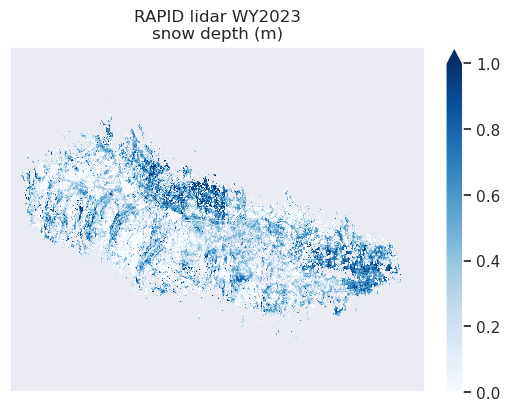

In [15]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5,4), constrained_layout = True)

ds.hs_rapid.plot(cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})

axes.set_title('RAPID lidar WY2023\nsnow depth (m)')

axes.set_xlabel('')
axes.set_ylabel('') 
axes.set_xticks([])
axes.set_yticks([])

plt.show()

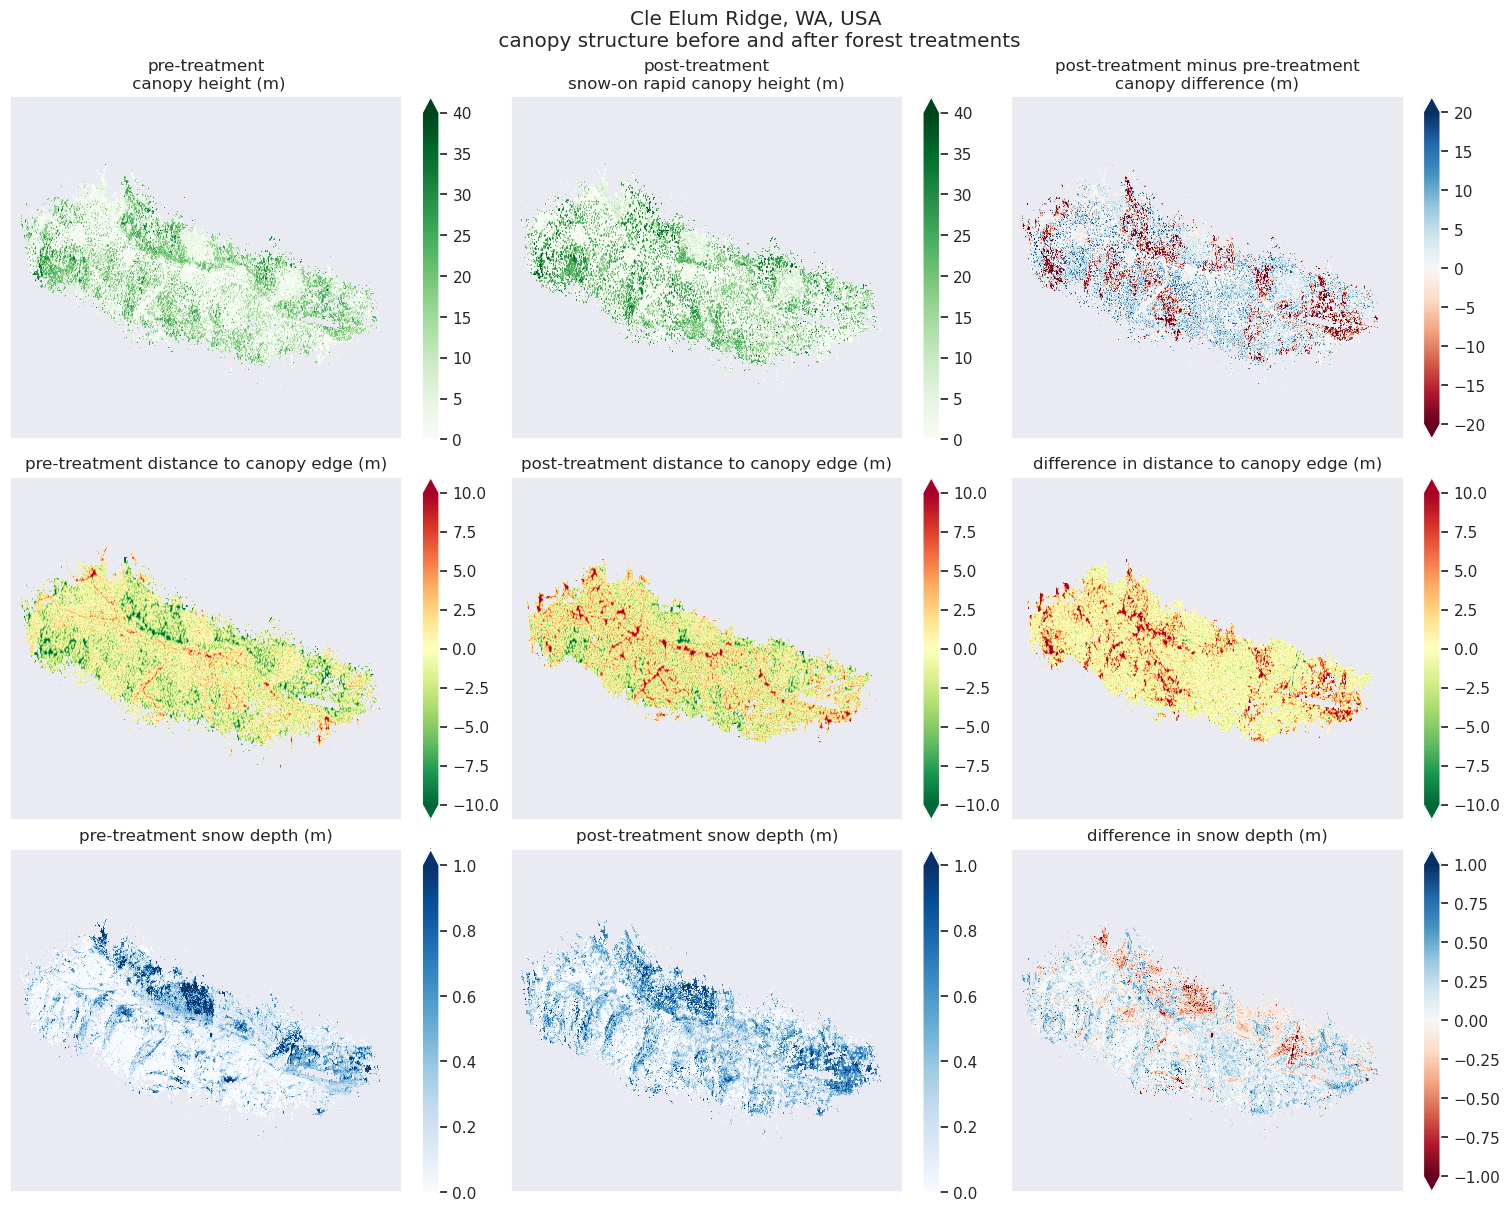

In [16]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15,12), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment snow depth (m)')
axes[2,1].set_title('post-treatment snow depth (m)')
axes[2,2].set_title('difference in snow depth (m)')


# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])
plt.show()

Space to add the random forest model prediction

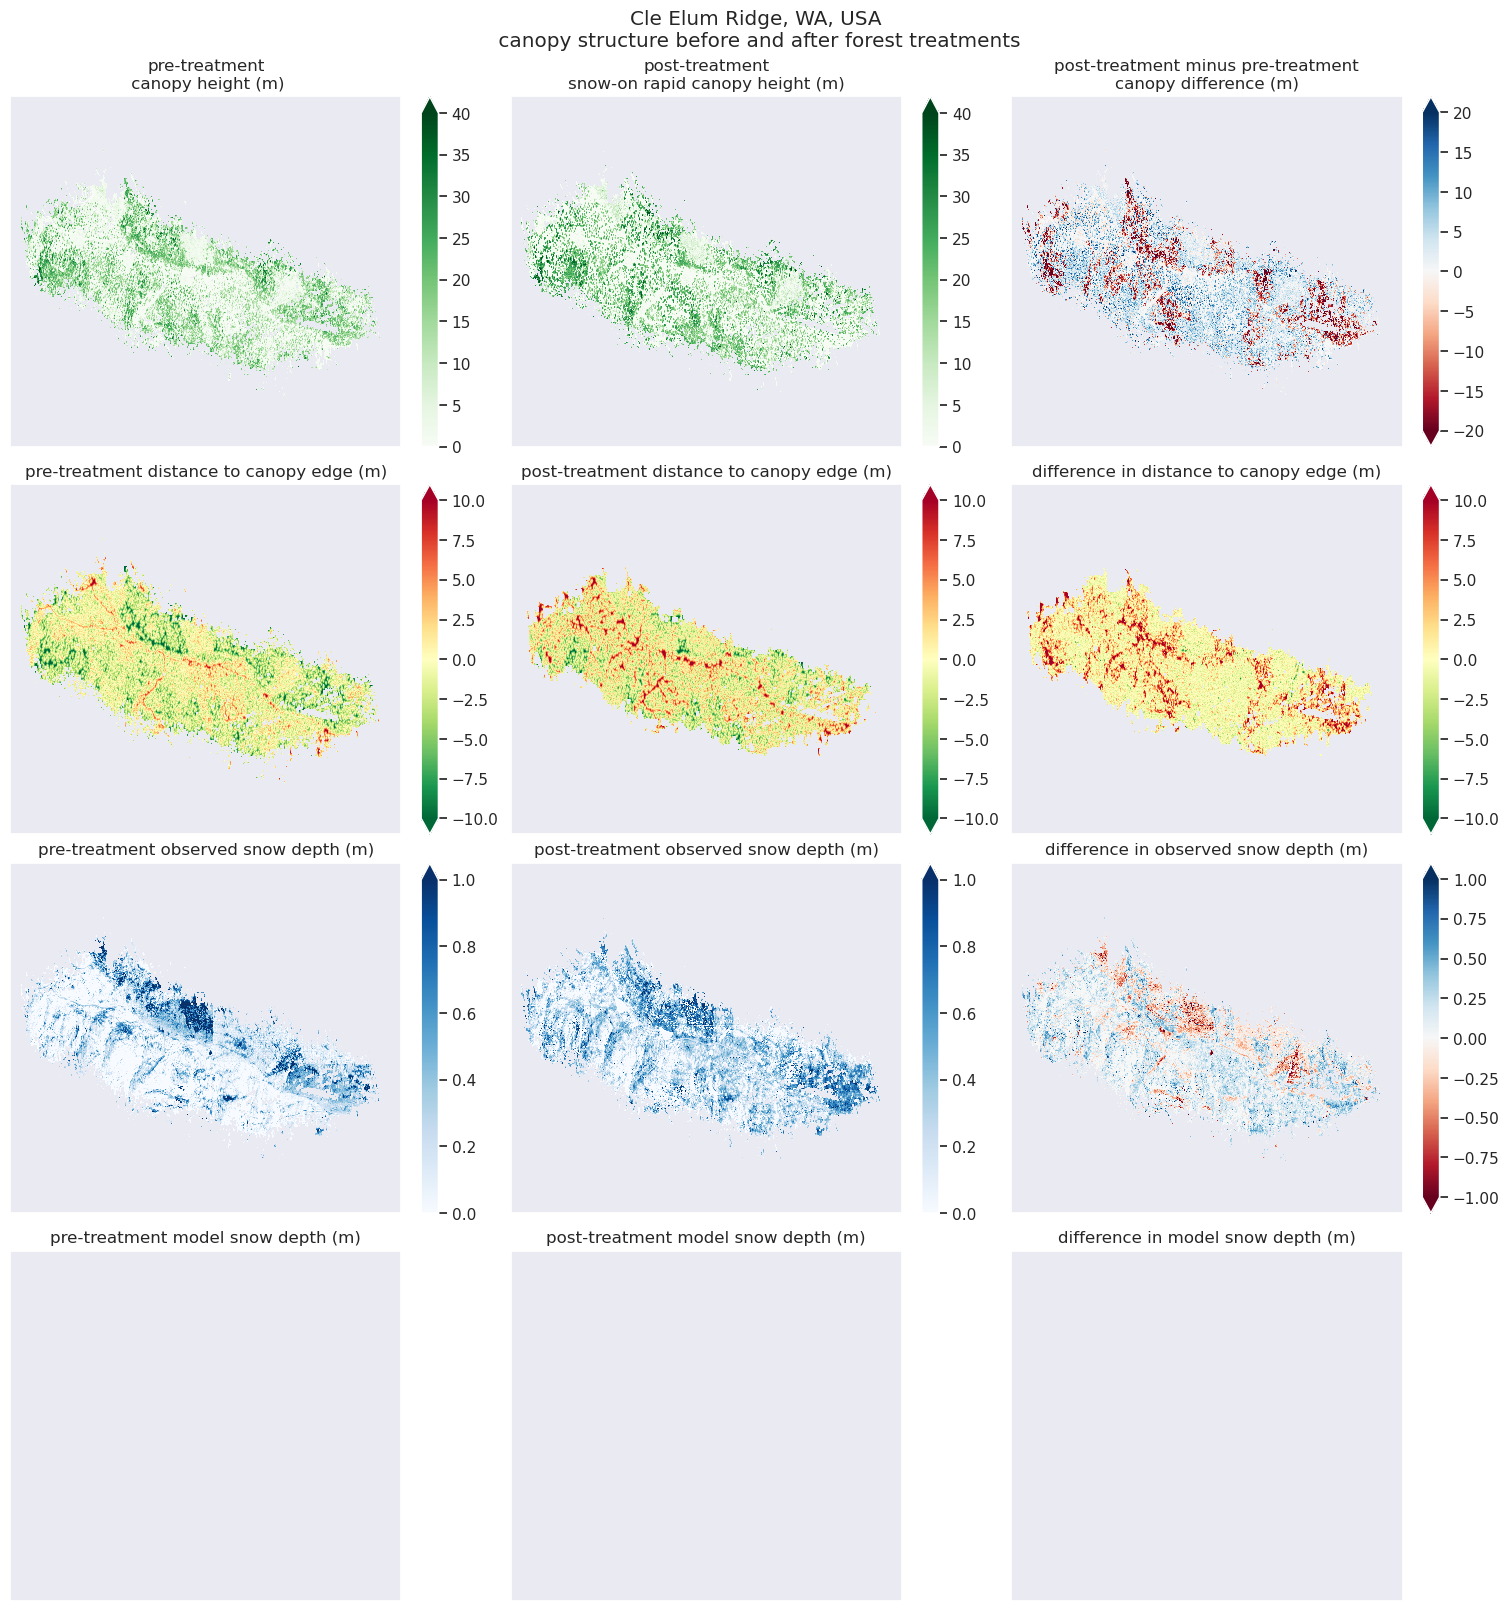

In [17]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)



axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')



# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])
plt.show()

## Test load the random forest model

The script is in,\
\home\lumbraca\raster\python\NCALM_raster_analysis\random_forest\AllSites_RandomForest_3_bin1redo

In [18]:
import pickle

In [44]:
filename = '/home/lumbraca/raster/data/random_forest_results/randomforest_bin1_1000.pkl'
# pickle.dump(clf1, open(filename, 'wb')) # wb, writing 

loaded_model = pickle.load(open(filename, 'rb')) # rb, reading 
# result = loaded_model.score(X_test, y_test)
# print(result)

In [45]:
# Read the dataset 1 at a time
# ds_pre = xr.open_dataset('/home/lumbraca/raster/data/cer_model_cleandata_create_netcdf.nc')
ds_pre = ds.copy(deep=True)

# Flatten
pre_snowdepth = ds_pre.hs_ncalm.values.flatten()
# pre_dem = ds_pre.dem.values.flatten()
pre_dah = ds_pre.dah.values.flatten() 
pre_dce = ds_pre.dce_ncalm.values.flatten()
pre_tpi = ds_pre.tpi.values.flatten() 

pre_dah = pre_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
pre_tpi = pre_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# # Subsample (we do not want to subsample for the model run)
# # decide how big to sample 
# sample_number = 10
# num = sample_number

# pre_snowdepth = pre_snowdepth[::num] #start:stop:step
# # pre_dem = pre_dem[::num] 
# pre_dce = pre_dce[::num] 
# pre_dah = pre_dah[::num] 
# pre_tpi = pre_tpi[::num] 

# Create DF for the site 
df_pre = pd.DataFrame({'snowdepth': pre_snowdepth,
                #    'dem': pre_dem, 
                   'dah': pre_dah, 
                   'tpi': pre_tpi,
                   'dce': pre_dce})

# # random forest cannot have any na values
# df_pre.dropna(how='any', inplace=True) # it has to be everything 
# instead of removing na, can we try filling it with something insane then removing those cells later?
df_pre = df_pre.fillna(1000) 

In [54]:
# Read the dataset 1 at a time
ds_post = ds.copy(deep=True)

# Flatten
post_snowdepth = ds_post.hs_rapid.values.flatten()
# post_dem = ds_post.dem.values.flatten()
post_dah = ds_post.dah.values.flatten() 
post_dce = ds_post.dce_rapid.values.flatten()
post_tpi = ds_post.tpi.values.flatten() 

post_dah = post_dah * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis
post_tpi = post_tpi * 100 # we want to multiply this by 100 to perserve the 2 decimal places for analysis

# # Subsample (we do not want to subsample for the model run)
# # decide how big to sample 
# sample_number = 10
# num = sample_number

# post_snowdepth = post_snowdepth[::num] #start:stop:step
# # post_dem = post_dem[::num] 
# post_dce = post_dce[::num] 
# post_dah = post_dah[::num] 
# post_tpi = post_tpi[::num] 

# Create DF for the site 
df_post = pd.DataFrame({'snowdepth': post_snowdepth,
                #    'dem': post_dem, 
                   'dah': post_dah, 
                   'tpi': post_tpi,
                   'dce': post_dce})

# random forest cannot have any na values
# df_post.dropna(how='any', inplace=True) # it has to be everything 

# instead of removing na, can we try filling it with something insane then removing those cells later?
df_post = df_post.fillna(1000) 

In [55]:
# check if there are any nans 
df_post

,snowdepth,dah,tpi,dce
0,1000.0,1000.0,1000.0,1000.0
1,1000.0,1000.0,1000.0,1000.0
2,1000.0,1000.0,1000.0,1000.0
3,1000.0,1000.0,1000.0,1000.0
4,1000.0,1000.0,1000.0,1000.0
...,...,...,...,...
3558827,1000.0,1000.0,1000.0,1000.0
3558828,1000.0,1000.0,1000.0,1000.0
3558829,1000.0,1000.0,1000.0,1000.0
3558830,1000.0,1000.0,1000.0,1000.0


<Axes: >

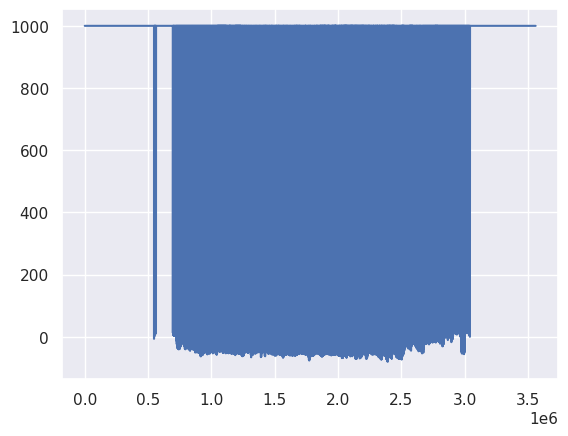

In [80]:
df_post.dah.plot()

In [85]:
# # If they need to be integers for the model, then do this
# df_pre_int = df_pre.copy(deep=True)
# df_pre_int['snowdepth'] = df_pre_int['snowdepth'].astype(int)
# # df_pre_int['dem'] = df_pre_int['dem'].astype(int)
# df_pre_int['dah'] = df_pre_int['dah'].astype(int)
# df_pre_int['dce'] = df_pre_int['dce'].astype(int)
# df_pre_int['tpi'] = df_pre_int['tpi'].astype(int)

# df_pre_int.head()

df_post_int = df_post.copy(deep=True)
df_post_int['snowdepth'] = df_post_int['snowdepth'].astype(int)
# df_post_int['dem'] = df_post_int['dem'].astype(int)
df_post_int['dah'] = df_post_int['dah'].astype(int)
df_post_int['dce'] = df_post_int['dce'].astype(int)
df_post_int['tpi'] = df_post_int['tpi'].astype(int)

df_post_int.head()

# create the x, variables, columns
X_pre = df_pre_int.drop(columns=['snowdepth'])
X_post = df_post_int.drop(columns=['snowdepth'])
X_post.head()

,dah,tpi,dce
0,1000,1000,1000
1,1000,1000,1000
2,1000,1000,1000
3,1000,1000,1000
4,1000,1000,1000


In [84]:
# if they do not need to be integers, then 
# create the x, variables, columns
X_pre = df_pre.drop(columns=['snowdepth'])
X_post = df_post.drop(columns=['snowdepth'])
X_post.head()

,dah,tpi,dce
0,1000.0,1000.0,1000.0
1,1000.0,1000.0,1000.0
2,1000.0,1000.0,1000.0
3,1000.0,1000.0,1000.0
4,1000.0,1000.0,1000.0


In [86]:
# Now, use the random forest model to predict 
# hs_ncalm_model = loaded_model.predict(X_pre)
hs_rapid_model_numpy = loaded_model.predict(X_post)

In [87]:
# # convert the model to a pandas array 
hs_rapid_model_pandas = pd.Series(hs_rapid_model_numpy)
# hs_ncalm_model_pandas = pd.Series(hs_ncalm_model_numpy)

# # convert the observations to a pandas array
hs_rapid_obs = pd.Series(ds.hs_rapid.values.flatten())
# hs_ncalm_obs = pd.Series(ds.hs_ncalm.values.flatten())

In [88]:
ds['hs_rapid_model'] = xr.DataArray(hs_rapid_model_numpy.reshape(ds.dims['y'], ds.dims['x']), dims = ['y','x'])

In [89]:
# fill the model with nan where the obs is nan 
ds['hs_rapid_model'] = ds['hs_rapid_model'].where(ds['hs_rapid'].notnull())

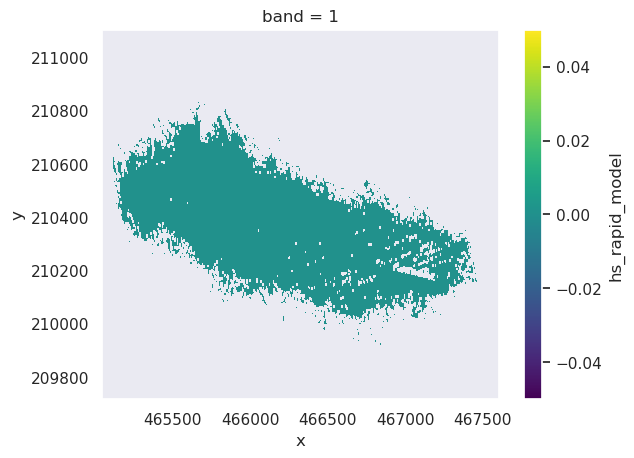

In [90]:
ds['hs_rapid_model'].plot()

In [ ]:
fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(15,16), constrained_layout = True)

fig.suptitle('Cle Elum Ridge, WA, USA\n canopy structure before and after forest treatments')

# row 1
# ds.chm_snowoff.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_ncalm.plot(ax=axes[0,0], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
ds.chmws_rapid.plot(ax=axes[0,1], cmap='Greens', vmin=0, vmax=40, cbar_kwargs={'label':''}) 
# ds.diff_chm_rapid_snowoff.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 
ds.diff_chm_rapid_ncalm.plot(ax=axes[0,2], cmap='RdBu', vmin=-20, vmax=20, cbar_kwargs={'label':''}) 

axes[0,0].set_title('pre-treatment\n canopy height (m)')
axes[0,1].set_title('post-treatment\nsnow-on rapid canopy height (m)')
axes[0,2].set_title('post-treatment minus pre-treatment\ncanopy difference (m)')

# row 2
ds.dce_ncalm.plot(ax=axes[1,0], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.dce_rapid.plot(ax=axes[1,1], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})
ds.diff_dce_rapid_ncalm.plot(ax=axes[1,2], cmap='RdYlGn_r', vmin=-10, vmax=10, cbar_kwargs={'label':''})

axes[1,0].set_title('pre-treatment distance to canopy edge (m)')
axes[1,1].set_title('post-treatment distance to canopy edge (m)')
axes[1,2].set_title('difference in distance to canopy edge (m)')

# row 3 
ds.hs_ncalm.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[2,0].set_title('pre-treatment observed snow depth (m)')
axes[2,1].set_title('post-treatment observed snow depth (m)')
axes[2,2].set_title('difference in observed snow depth (m)')

# row 4 (random forest model results)
ds.hs_ncalm_model.plot(ax=axes[2,0], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.hs_rapid_model.plot(ax=axes[2,1], cmap='Blues', vmin=0, vmax=1, cbar_kwargs={'label':''})
ds.diff_hs_rapid_ncalm_model.plot(ax=axes[2,2], cmap='RdBu', vmin=-1, vmax=1, cbar_kwargs={'label':''})

axes[3,0].set_title('pre-treatment model snow depth (m)')
axes[3,1].set_title('post-treatment model snow depth (m)')
axes[3,2].set_title('difference in model snow depth (m)')



# some constants 
# row 1 
axes[0,0].set_xlabel(''); axes[0,0].set_ylabel(''); axes[0,0].set_xticks([]); axes[0,0].set_yticks([])
axes[0,1].set_xlabel(''); axes[0,1].set_ylabel(''); axes[0,1].set_xticks([]); axes[0,1].set_yticks([])
axes[0,2].set_xlabel(''); axes[0,2].set_ylabel(''); axes[0,2].set_xticks([]); axes[0,2].set_yticks([])

# row 2
axes[1,0].set_xlabel(''); axes[1,0].set_ylabel(''); axes[1,0].set_xticks([]); axes[1,0].set_yticks([])
axes[1,1].set_xlabel(''); axes[1,1].set_ylabel(''); axes[1,1].set_xticks([]); axes[1,1].set_yticks([])
axes[1,2].set_xlabel(''); axes[1,2].set_ylabel(''); axes[1,2].set_xticks([]); axes[1,2].set_yticks([])

# row 3 
axes[2,0].set_xlabel(''); axes[2,0].set_ylabel(''); axes[2,0].set_xticks([]); axes[2,0].set_yticks([])
axes[2,1].set_xlabel(''); axes[2,1].set_ylabel(''); axes[2,1].set_xticks([]); axes[2,1].set_yticks([])
axes[2,2].set_xlabel(''); axes[2,2].set_ylabel(''); axes[2,2].set_xticks([]); axes[2,2].set_yticks([])

# row 4 
axes[3,0].set_xlabel(''); axes[3,0].set_ylabel(''); axes[3,0].set_xticks([]); axes[3,0].set_yticks([])
axes[3,1].set_xlabel(''); axes[3,1].set_ylabel(''); axes[3,1].set_xticks([]); axes[3,1].set_yticks([])
axes[3,2].set_xlabel(''); axes[3,2].set_ylabel(''); axes[3,2].set_xticks([]); axes[3,2].set_yticks([])
plt.show()

In [ ]:
# # now, we want to calculate the difference between the observed and predicted snow depth
# ds['diff_hs_ncalm_model'] = ds['hs_ncalm_model'] - ds['hs_ncalm']
# ds['diff_hs_rapid_model'] = ds['hs_rapid_model'] - ds['hs_rapid']

In [79]:
# # this is a func that is meant to stand in place for your transform
# # def cassie_transform(inputarray, multiplyby=10):
# #     return inputarray * multiplyby

# transformed_arr = hs_rapid_model.copy() 

# # orig_arr = np.array([[0, 1, np.nan],
# #                      [1, np.nan, 3],
# #                      [2, np.nan, np.nan]])
# # print(orig_arr)

# orig_arr = hs_rapid_obs_np.copy()
# print(orig_arr.shape)

# # keep only the not nan values from original array to work on
# raveled_arr = orig_arr[~np.isnan(orig_arr)]
# print(raveled_arr.shape)

# # do what you gotta do, assuming it yields the same shape of vals
# # transformed_arr = cassie_transform(raveled_arr)
# print(transformed_arr.shape)

# # copy your original array format
# new_arr = copy.deepcopy(orig_arr)

# # pop the transformed values back into the correct spots
# new_arr[~np.isnan(new_arr)] = transformed_arr
# print(new_arr)